In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Import Libraries

In [14]:
import numpy as np
import pandas as pd
import random
import torch
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from collections import Counter
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix, accuracy_score
#from imblearn.metrics import geometric_mean_score
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Dataset Info

In [3]:
dataset_path = '/kaggle/input/forarsenicmrg/For_Arsenic_Merge_v2'  

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        num_images = len(os.listdir(category_path))
        print(f"{category}: {num_images} images")


acne vulgaris: 2 images
Monkeypox: 2 images
Hand Foot and Mouth Disease: 1 images
Melanoma: 3 images
Measles: 2 images
Tinea Corporis: 2 images
scabies: 2 images
pityriasis versicolor: 1 images
lichen planus: 3 images
Normal: 3 images
Actinic Keratosis: 4 images
Squamous Cell Carcinoma: 3 images
vitiligo: 3 images
Basal Cell Carcinoma: 4 images
Arsenic: 2 images
Chickenpox: 2 images
seborrheic dermatitis: 3 images
Seborrheic Keratosis: 3 images
Nevus: 1 images
Cowpox: 1 images


In [4]:
from torchvision import datasets

dataset = datasets.ImageFolder(root='/kaggle/input/forarsenicmrg/For_Arsenic_Merge_v2')
dataset

Dataset ImageFolder
    Number of datapoints: 11989
    Root location: /kaggle/input/forarsenicmrg/For_Arsenic_Merge_v2

In [5]:
class_names = dataset.classes
class_names

['Actinic Keratosis',
 'Arsenic',
 'Basal Cell Carcinoma',
 'Chickenpox',
 'Cowpox',
 'Hand Foot and Mouth Disease',
 'Measles',
 'Melanoma',
 'Monkeypox',
 'Nevus',
 'Normal',
 'Seborrheic Keratosis',
 'Squamous Cell Carcinoma',
 'Tinea Corporis',
 'acne vulgaris',
 'lichen planus',
 'pityriasis versicolor',
 'scabies',
 'seborrheic dermatitis',
 'vitiligo']

In [6]:
num_classes = len(class_names)
num_classes 

20

In [7]:
# dataset.targets has numeric labels for each image
counts = Counter(dataset.targets)

# Map counts to class names
for class_idx, count in counts.items():
    print(f"{dataset.classes[class_idx]}: {count} images")

Actinic Keratosis: 951 images
Arsenic: 819 images
Basal Cell Carcinoma: 1599 images
Chickenpox: 482 images
Cowpox: 330 images
Hand Foot and Mouth Disease: 805 images
Measles: 366 images
Melanoma: 343 images
Monkeypox: 1699 images
Nevus: 244 images
Normal: 1409 images
Seborrheic Keratosis: 321 images
Squamous Cell Carcinoma: 730 images
Tinea Corporis: 176 images
acne vulgaris: 393 images
lichen planus: 474 images
pityriasis versicolor: 148 images
scabies: 314 images
seborrheic dermatitis: 181 images
vitiligo: 205 images


In [8]:
# Create DataFrame
df_counts = pd.DataFrame({
    "Class": [dataset.classes[idx] for idx in counts.keys()],
    "Count": [counts[idx] for idx in counts.keys()]
})

# Save to CSV
df_counts.to_csv("class_counts.csv", index=False)

print("Counts saved to class_counts.csv")

Counts saved to class_counts.csv


# Visualization

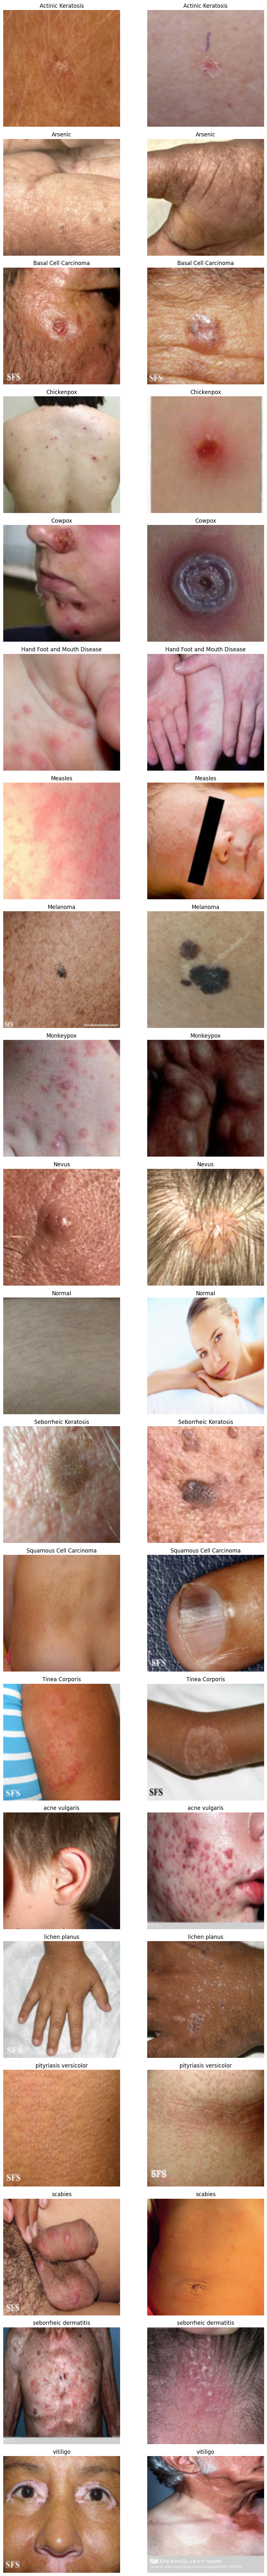

In [15]:
fixed_size = (128, 128)  # (width, height) for display

# Prepare a figure
fig, axes = plt.subplots(len(dataset.classes), samples_per_class,
                         figsize=(5 * samples_per_class, 4 * len(dataset.classes)))

# Loop over each class
for class_idx, class_name in enumerate(dataset.classes):
    # Get indices for this class
    class_indices = [i for i, label in enumerate(dataset.targets) if label == class_idx]
    
    # Randomly choose images from this class
    chosen_indices = random.sample(class_indices, samples_per_class)
    
    for i, idx in enumerate(chosen_indices):
        image, label = dataset[idx]

        # Convert tensor to PIL if needed
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)

        # Resize image for display
        image = image.resize(fixed_size)

        ax = axes[class_idx, i] if samples_per_class > 1 else axes[class_idx]
        ax.imshow(image)
        ax.set_title(class_name)
        ax.axis("off")

plt.tight_layout()
plt.show()

In [17]:
import os
import random
import matplotlib.pyplot as plt
import torch

# Ensure output directory exists
os.makedirs("class_samples", exist_ok=True)

samples_per_class = 2
fixed_size = (128, 128)  # Resize for plotting

for class_idx, class_name in enumerate(dataset.classes):
    class_indices = [i for i, label in enumerate(dataset.targets) if label == class_idx]
    chosen_indices = random.sample(class_indices, samples_per_class)
    
    fig, axes = plt.subplots(1, samples_per_class, figsize=(5 * samples_per_class, 4))
    if samples_per_class == 1:
        axes = [axes]  # Make iterable
    
    for ax, idx in zip(axes, chosen_indices):
        image, _ = dataset[idx]
        
        # Handle tensor or PIL image
        if torch.is_tensor(image):
            image = image.permute(1, 2, 0).numpy()
        
        # Resize with PIL
        image = image.resize(fixed_size) if hasattr(image, "resize") else plt.imshow(image)
        
        ax.imshow(image)
        ax.axis("off")
    
    fig.suptitle(class_name, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Leave space for title
    
    pdf_path = f"class_samples/{class_name}.pdf"
    png_path = f"class_samples/{class_name}.png"
    plt.savefig(pdf_path)
    plt.savefig(png_path, dpi=600)
    plt.close(fig)

print("Figures saved in 'class_samples' folder.")


Figures saved in 'class_samples' folder.


In [18]:
import shutil

# Zip the output folder
shutil.make_archive('/kaggle/working/output_files', 'zip', '/kaggle/working')

# This will create /kaggle/working/output_files.zip

'/kaggle/working/output_files.zip'

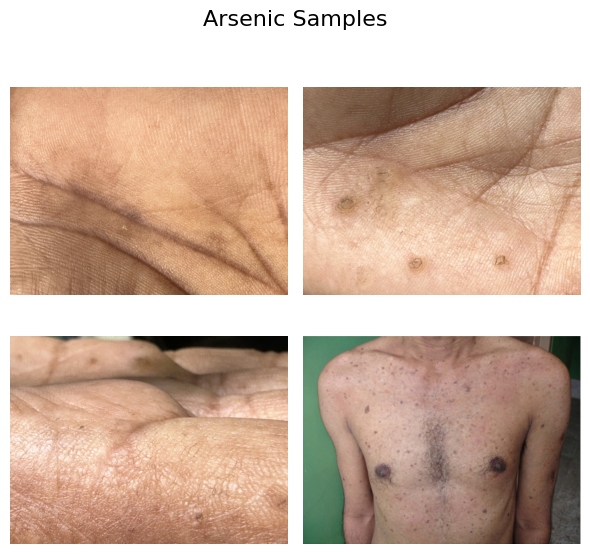

In [20]:
import matplotlib.pyplot as plt
import random

# Define target category
target_class = "Arsenic"

# Find the index for the target class
target_class_idx = dataset.classes.index(target_class)

# Get all indices for that class
class_indices = [i for i, label in enumerate(dataset.targets) if label == target_class_idx]

# Choose 4 random images
chosen_indices = random.sample(class_indices, 4)

# Create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

for ax, idx in zip(axes.flat, chosen_indices):
    image, label = dataset[idx]
    
    # If image is a Tensor (C,H,W), convert to numpy
    if hasattr(image, 'permute'):
        image = image.permute(1, 2, 0)  # C,H,W → H,W,C
    
    ax.imshow(image)
    ax.axis("off")

# Set a single title for the figure
fig.suptitle(f"{target_class.capitalize()} Samples", fontsize=16)

plt.tight_layout()
plt.show()

# Optionally save
fig.savefig(f"{target_class}_2x2_block.png", dpi=300)
fig.savefig(f"{target_class}_2x2_block.pdf")


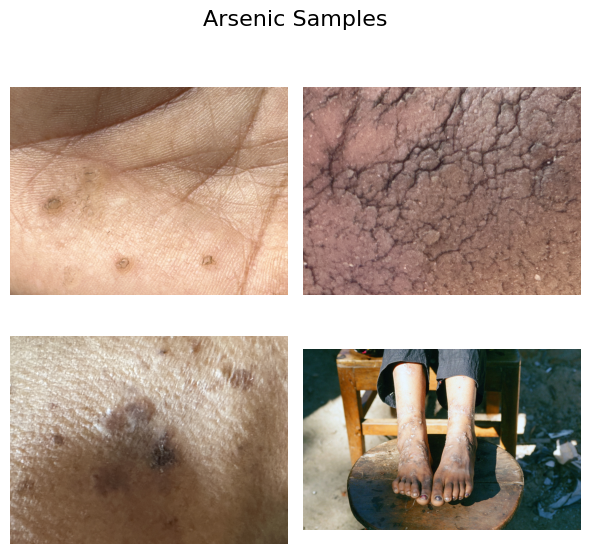

In [22]:
import matplotlib.pyplot as plt
import random

# Define target category
target_class = "Arsenic"

# Find the index for the target class
target_class_idx = dataset.classes.index(target_class)

# Get all indices for that class
class_indices = [i for i, label in enumerate(dataset.targets) if label == target_class_idx]

# Choose 4 random images
chosen_indices = random.sample(class_indices, 4)

# Create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

for ax, idx in zip(axes.flat, chosen_indices):
    image, label = dataset[idx]
    
    # If image is a Tensor (C,H,W), convert to numpy
    if hasattr(image, 'permute'):
        image = image.permute(1, 2, 0)  # C,H,W → H,W,C
    
    ax.imshow(image)
    ax.axis("off")

# Set a single title for the figure
fig.suptitle(f"{target_class.capitalize()} Samples", fontsize=16)

plt.tight_layout()
plt.show()

# Optionally save
fig.savefig(f"{target_class}_2x2_block_2.png", dpi=300)
fig.savefig(f"{target_class}_2x2_block_2.pdf")
